In [1]:
import sys
try:
    from google.colab import drive
    drive.mount("/content/drive")
    main_path = '/content/drive/My Drive/lee_mcc9/'
except:
    main_path = ''
sys.path.append(main_path)

In [106]:
import plotter
import importlib
importlib.reload(plotter)
import uproot
import matplotlib.pylab as pylab
import numpy as np
import math
from sklearn.model_selection import train_test_split
import pickle
import xgboost as xgb
import nue_booster 
importlib.reload(nue_booster)

params = {
    'axes.labelsize': 'x-large',
    'axes.titlesize': 'x-large',
    'xtick.labelsize': 'x-large',
    'ytick.labelsize': 'x-large'
}
pylab.rcParams.update(params)


In [74]:
fold = "nuselection"
tree = "NeutrinoSelectionFilter"

mc = uproot.open(main_path+"root_files/mc_bnb.root")[fold][tree]
nc = uproot.open(main_path+"root_files/nc.root")[fold][tree]
nue = uproot.open(main_path+"root_files/nue.root")[fold][tree]
data = uproot.open(main_path+"root_files/bnb.root")[fold][tree]
ext = uproot.open(main_path+"root_files/ext.root")[fold][tree]
dirt = uproot.open(main_path+"root_files/dirt.root")[fold][tree]
lee = uproot.open(main_path+"root_files/nue.root")[fold][tree]

variables = [
    "shr_dedx_Y", "shr_bkt_pdg", "p", "pt", "selected", "nu_pdg", "shr_theta",
    "slpdg", "trk_score_v", "backtracked_pdg", "shr_theta_v", "shr_score_v",
    "shr_pfp_id_v", "category", "shr_tkfit_dedx_Y", "trk_pfp_id",
    "shr_energy_tot", "trk_energy_tot", "shr_hits_tot", "ccnc", "trk_chipr",
    "trk_bkt_pdg", "hits_ratio", "n_tracks_contained", 
    "nproton", "nu_e", "n_showers_contained", "shr_distance", "trk_distance",
    "hits_y", "shr_pz", "shr_energy", "shr_dedx_U", "shr_dedx_V", "shr_phi", "trk_phi", "trk_theta",
    "shr_tkfit_dedx_U", "shr_tkfit_dedx_V", "run", "sub", "evt", "nproton", "trk_pid_chipr_v",
    "trk_len", "mc_pdg", "slnunhits", "slnhits", "shr_score", "trk_score", "trk_hits_tot",
    "true_e_visible", "matched_E", "shr_bkt_E", "trk_bkt_E", "trk_energy", "tksh_distance", "tksh_angle",
    "trk_chipr_best", "trk_chipr_worst", "trk_pida", "trk_chimu", "CosmicIP", "trk_bragg_p", "trk_bragg_mu",
    "trk_bragg_mip", "shr_chipr", "shr_bragg_p", "shr_bragg_mu", "shr_chimu",
    "shr_pca_2", "shr_pca_0", "shr_pca_1", "npi0", "gamma1_edep", "gamma2_edep", "topological_score",
    "pi0_e", "shr_energy_tot_cali", "shr_dedx_Y_cali"
]

mc = mc.pandas.df(variables, flatten=False)
nc = nc.pandas.df(variables, flatten=False)
nue = nue.pandas.df(variables, flatten=False)
data = data.pandas.df(variables, flatten=False)
ext = ext.pandas.df(variables, flatten=False)
dirt = dirt.pandas.df(variables, flatten=False)
lee = lee.pandas.df(variables + ["leeweight"], flatten=False)

ext["shr_dedx_Y"] = ext["shr_dedx_Y"] * 1.0411
data["shr_dedx_Y"] = data["shr_dedx_Y"] * 1.0411
ext["shr_dedx_Y_cali"] = ext["shr_dedx_Y_cali"] * 1.0411
data["shr_dedx_Y_cali"] = data["shr_dedx_Y_cali"] * 1.0411
ext["shr_tkfit_dedx_Y"] = ext["shr_tkfit_dedx_Y"] * 1.0411
data["shr_tkfit_dedx_Y"] = data["shr_tkfit_dedx_Y"] * 1.0411
ext["shr_energy_tot"] = ext["shr_energy_tot"] * 1.0411
data["shr_energy_tot"] = data["shr_energy_tot"] * 1.0411
ext["shr_energy_tot_cali"] = ext["shr_energy_tot_cali"] * 1.0411
data["shr_energy_tot_cali"] = data["shr_energy_tot_cali"] * 1.0411

lee["is_signal"] = lee["category"] == 11
data["is_signal"] = data["category"] == 11
nue["is_signal"] = nue["category"] == 11
mc["is_signal"] = mc["category"] == 11
dirt["is_signal"] = dirt["category"] == 11
ext["is_signal"] = ext["category"] == 11
nc["is_signal"] = nc["category"] == 11

lee.loc[lee['category'] == 1, 'category'] = 111
lee.loc[lee['category'] == 10, 'category'] = 111
lee.loc[lee['category'] == 11, 'category'] = 111

train_nc, nc = train_test_split(nc, test_size=0.5, random_state=1990)
train_mc, mc = train_test_split(mc, test_size=0.5, random_state=1990)
train_nue, nue = train_test_split(nue, test_size=0.5, random_state=1990)
train_lee, lee = train_test_split(lee, test_size=0.5, random_state=1990)
train_ext, ext = train_test_split(ext, test_size=0.5, random_state=1990)

In [26]:
features = nue_booster.variables.copy()
features.remove("is_signal")
features.remove("nu_e")
features.remove("train_weight")

for label, bkg_query in zip(nue_booster.labels, nue_booster.bkg_queries):
    with open(main_path+'pickles/booster_%s.pickle' % label, 'rb') as booster_file:
        booster = pickle.load(booster_file)
        mc[label+"_score"] = booster.predict(
            xgb.DMatrix(mc[features]),
            ntree_limit=booster.best_iteration + 1)
        nue[label+"_score"] = booster.predict(
            xgb.DMatrix(nue[features]),
            ntree_limit=booster.best_iteration + 1)
        ext[label+"_score"] = booster.predict(
            xgb.DMatrix(ext[features]),
            ntree_limit=booster.best_iteration + 1)
        data[label+"_score"] = booster.predict(
            xgb.DMatrix(data[features]),
            ntree_limit=booster.best_iteration + 1)
        dirt[label+"_score"] = booster.predict(
            xgb.DMatrix(dirt[features]),
            ntree_limit=booster.best_iteration + 1)
        lee[label+"_score"] = booster.predict(
            xgb.DMatrix(lee[features]),
            ntree_limit=booster.best_iteration + 1)
        nc[label+"_score"] = booster.predict(
            xgb.DMatrix(nc[features]),
            ntree_limit=booster.best_iteration + 1)
features = ["%s_score" % l for l in nue_booster.labels]

with open(main_path+'pickles/booster.pickle', 'rb') as booster_file:
    booster = pickle.load(booster_file)
    
    mc["global_score"] = booster.predict(
        xgb.DMatrix(mc[features]),
        ntree_limit=booster.best_iteration + 1)
    nue["global_score"] = booster.predict(
        xgb.DMatrix(nue[features]),
        ntree_limit=booster.best_iteration + 1)
    ext["global_score"] = booster.predict(
        xgb.DMatrix(ext[features]),
        ntree_limit=booster.best_iteration + 1)
    data["global_score"] = booster.predict(
        xgb.DMatrix(data[features]),
        ntree_limit=booster.best_iteration + 1)
    dirt["global_score"] = booster.predict(
        xgb.DMatrix(dirt[features]),
        ntree_limit=booster.best_iteration + 1)
    lee["global_score"] = booster.predict(
        xgb.DMatrix(lee[features]),
        ntree_limit=booster.best_iteration + 1)
    nc["global_score"] = booster.predict(
        xgb.DMatrix(nc[features]),
        ntree_limit=booster.best_iteration + 1)

In [88]:
genie_bins = [0., 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 
      0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 
      0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 
      0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 
      0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 
      0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 
      0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 
      0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 
      0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 
      0.99, 1., 10]
genie_scaling = [
      12.55208598,  12.55208598, 12.55208598, 12.55208598, 12.55208598,
      12.55208598,  12.55208598, 12.55208598, 12.55208598, 12.55208598,
      12.55208598,  12.55208598, 12.55208598, 12.55208598,  9.31846454,
       6.82872663,  5.80966896,  5.2553157 ,  4.90681857,  4.66746843,
       4.4929316 ,  4.36002138,  4.25543261,  4.17098451,  4.1013703 ,
       4.04299703,  3.99334541,  3.63941611,  3.3721562 ,  3.16703429,
       3.00463658,  2.87287377,  2.76382449,  2.67208169,  2.59382834,
       2.52629307,  2.46741497,  2.41562971,  2.36972842,  2.30539259,
       2.22447089,  2.15393863,  2.09191567,  2.03694972,  1.98790119,
       1.94386331,  1.90410559,  1.86803295,  1.83515574,  1.80506736,
       1.77742741,  1.75194872,  1.72135466,  1.6927084 ,  1.66611657,
       1.64136581,  1.61827133,  1.59667225,  1.57642788,  1.55741465,
       1.53952356,  1.52265812,  1.5067326 ,  1.49167054,  1.47724255,
       1.4633238 ,  1.45005827,  1.43740101,  1.42531113,  1.41375131,
       1.40268745,  1.39208829,  1.38192516,  1.37217169,  1.36280362,
       1.35379853,  1.34513573,  1.3382099 ,  1.33160516,  1.32520344,
       1.31899553,  1.31297276,  1.30712696,  1.30145044,  1.29593597,
       1.2905767 ,  1.28536616,  1.28029825,  1.2753672 ,  1.27093091,
       1.2670996 ,  1.26335683,  1.25969957,  1.25612491,  1.25263009,
       1.24921246,  1.2458695 ,  1.24259878,  1.23939799,  1.23626491,
       1.23319741,  1.2
]

nc["genie_weight"] = 1
nue["genie_weight"] = 1
mc["genie_weight"] = 1
dirt["genie_weight"] = 1
lee["genie_weight"] = 1

# for i, genie_bin in enumerate(genie_bins):
    
#     if i == 0:
#         continue
        
#     nue.loc[(nue['nu_e'] > genie_bins[i-1]) & (nue['nu_e'] < genie_bins[i]), 'genie_weight'] = genie_scaling[i-1]
#     mc.loc[(mc['nu_e'] > genie_bins[i-1]) & (mc['nu_e'] < genie_bins[i]), 'genie_weight'] = genie_scaling[i-1]
#     dirt.loc[(dirt['nu_e'] > genie_bins[i-1]) & (dirt['nu_e'] < genie_bins[i]), 'genie_weight'] = genie_scaling[i-1]
#     nc.loc[(nc['nu_e'] > genie_bins[i-1]) & (nc['nu_e'] < genie_bins[i]), 'genie_weight'] = genie_scaling[i-1]
#     lee.loc[(lee['nu_e'] > genie_bins[i-1]) & (lee['nu_e'] < genie_bins[i]), 'genie_weight'] = genie_scaling[i-1]


In [107]:
lee["reco_e"] = (lee["shr_energy_tot_cali"] + 0.030) / 0.79 + lee["trk_energy_tot"]
data["reco_e"] = (data["shr_energy_tot_cali"] + 0.030) / 0.79 + data["trk_energy_tot"]
nue["reco_e"] = (nue["shr_energy_tot_cali"] + 0.030) / 0.79 + nue["trk_energy_tot"]
mc["reco_e"] = (mc["shr_energy_tot_cali"] + 0.030) / 0.79 + mc["trk_energy_tot"]
dirt["reco_e"] = (dirt["shr_energy_tot_cali"] + 0.030) / 0.79 + dirt["trk_energy_tot"]
ext["reco_e"] = (ext["shr_energy_tot_cali"] + 0.030) / 0.79 + ext["trk_energy_tot"]
nc["reco_e"] = (nc["shr_energy_tot_cali"] + 0.030) / 0.79 + nc["trk_energy_tot"]


samples = {
    "mc": mc,
    "nue": nue,
    "data": data,
    "ext": ext,
    "dirt": dirt,
    "nc": nc,
    "lee": lee
}

scaling = 1#132.0/4.5

weights = {
    "mc": 0.0349332 * 2 * scaling,
    "nue": 0.00037172 * 2 * scaling,
    "ext": .15639 * 2 * scaling,
    "dirt": 0.144746 * scaling,
    "lee": 0.00037172 * 2 * scaling,
    "nc": 0.017604 * 2 * scaling,
}

my_plotter = plotter.Plotter(samples, weights)

Profile likelihood: 0.00 sigma @ 1.32e21 POT
s/sqrt(b): 0.00 sigma @ 1.32e21 POT


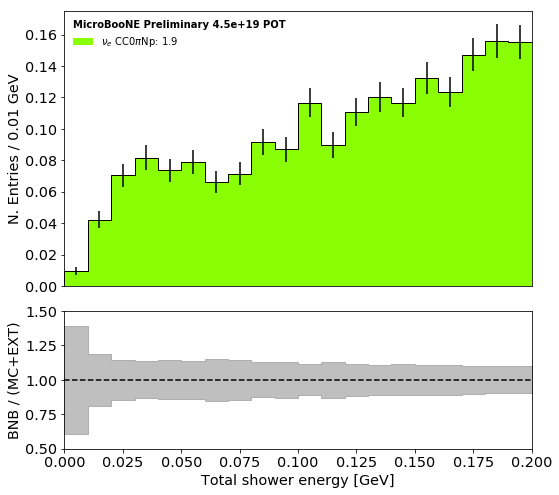

In [108]:
miniboone_bins = [
    0, 0.200, 0.300, 0.375, 0.475, 0.550, 0.675, 0.800, 0.950, 1.100, 1.300,
    1.500, 3.000
]

score_cut = 0.99941

# print(samples["data"].query("selected==1 & global_score > %g & cosmic_score > 0.995 & reco_e > 0.1 & reco_e < 0.6" % score_cut)[["run", "sub", "evt"]].to_string(index=False))

fig, ax1, ax2 = my_plotter.plot_variable(
    "shr_energy_tot_cali",
#     query="tksh_distance < 5 & tksh_angle < 0.9 & trk_chipr > 0 & hits_y > 100 & trk_chipr < 50 & pt/p < 0.9 & hits_ratio > 0.5 & selected==1 & shr_energy/shr_energy_tot > 0.9  & shr_distance < 5 & trk_distance < 2.5 & slpdg==12 & (shr_energy_tot+0.02)/0.8 > 0.06 & shr_tkfit_dedx_Y < 3.2 & shr_tkfit_dedx_Y > 0.7",
    query="selected==1 & category == 11",# & global_score > %g & cosmic_score > 0.995" % score_cut,
    kind="event_category",
    title=r"Total shower energy [GeV]",
#     bins=miniboone_bins,
    bins=20,
    range=(0,0.2)
)

# ax1.axvline(x=0, color="k")
# print(samples["mc"].query("selected==1 & global_score > %g & reco_e > 0.2 & reco_e < 0.8 & category != 11" % score_cut)[["run","sub","evt","shr_score", "category", "trk_chipr"]])

print("Profile likelihood: %.2f sigma @ 1.32e21 POT" % my_plotter.significance_likelihood)
print("s/sqrt(b): %.2f sigma @ 1.32e21 POT" % my_plotter.significance)

# ax1.set_ylim(0, 550)
# ax1.set_yscale("log")
# ax1.set_ylim(0,1)
# ax1.set_ylim(0,450)
fig.savefig(main_path+"plots/spectrum.pdf")